1. Сделать обзор всевозможных решений решений по применению ИИ в строительстве, проектировании и эксплуатации и продажи квартир, показать вашу экспертизу и подготовку.

В строительной отрасли нейронные сети можно использовать для обнаружения дефектов в стройматериалах, таких как бетон, сталь и дерево. Благодаря анализу больших объемов данных, включая изображения, можно выявлять дефекты, которые трудно обнаружить технадзору. 

Для профилактического обслуживания нейронные сети можно использовать для прогнозирования выхода оборудования из строя. Это может сократить время простоя и затраты на техническое обслуживание, а также повысить безопасность на строительных площадках.

Благодаря использованию фотометрии, видео и нейросетей на строительной площадке можно минимизировать потенциальные риски по охране труда. Анализируя данные с датчиков и других источников, нейронные сети могут прогнозировать вероятность возникновения аварий, что позволяет принимать превентивные меры.

Пример готовых решений:

John Porral создал проект The bedroom script: программе можно задать контур жилья, она анализирует его и создаёт варианты планировок. Дальше планировки могут объединяться в целые квартиры и таким образом появляются жилые дома, отвечающие потребностям людей.

Проект Spacemaker от компании Autodesk — облачный софт, использующий нейронные сети для генерации кварталов. Архитектор загружает проект в облако и создаёт варианты, при этом итерации происходят за минуты, а не за дни или недели, как это обычно происходит в ручном проектировании при CAD-софтах. Над Spacemaker работает архитектор Stanislas Chaillou, который в ранних экспериментах использовал генеративно-состязательные нейросети Pix2Pix для создания планировок в разных архитектурных стилях.

Компания XKOOL в сотрудничестве с OMA создала софт, в который можно загрузить свой проект жилой застройки, исследовать и редактировать его с точки зрения климата и функционального баланса территории. Важный инструмент для девелоперов, способный существенно улучшить планирование.

2. Провести описание подходов, которые вы планируете использовать для решения задачи.
Для решения данной задачи я буду использовать label-studio для разметки данных, нейронную сеть Unet для сегментации и библиотеку  opencv для подсчета числа окон.

In [1]:
#загружаем необъодимые библиотеки
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import skimage.draw
import os
import skimage.io

3.Собрать датасет на котором изображены многоквартирные жилые дома

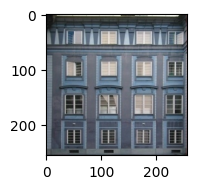

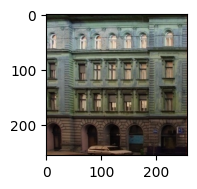

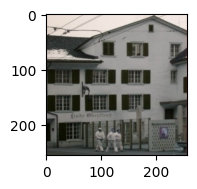

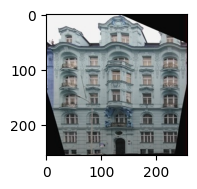

In [2]:
names = os.listdir('/home/mikhail/github/Facades/data/imgs')
for name in names[:4]:
    img = cv2.imread(f'/home/mikhail/github/Facades/data/imgs/{name}')
    plt.figure(figsize=(4,4))
    plt.subplot(1,2,1).imshow(img)

4.Провести необходимую для вас разметку датасета (сегментация фасада, окна)
Для разметки датасета использовалась библиотека label-studio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


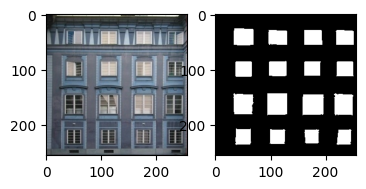

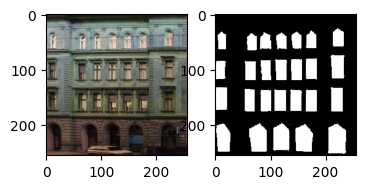

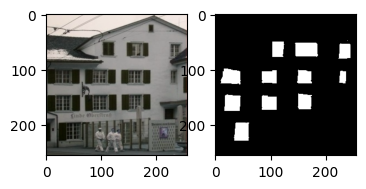

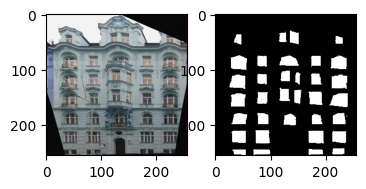

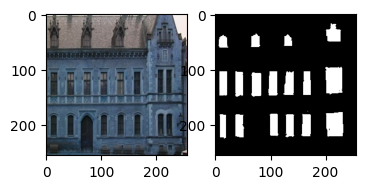

In [3]:
#Создание маски изображения
def preprocess_input(image, poligons, target_size=(256, 256), crop=None):
    ih, iw = target_size
    h, w, _ = image.shape
    scale = min(iw / w, ih / h)
    nw, nh = int(scale * w), int(scale * h)
    image_resized = cv2.resize(image, (nw, nh))
    image_paded = np.full(shape=[ih, iw, 3], fill_value=128.0)
    dw, dh = (iw - nw) // 2, (ih - nh) // 2
    image_paded[dh:nh + dh, dw:nw + dw, :] = image_resized
    image_paded = image_paded
    mask = np.zeros(target_size + (1,))
    for p in poligons:
        px = (np.array(p['all_points_x']) * scale*2.56).astype(int) + dw
        py = (np.array(p['all_points_y']) * scale*2.56).astype(int) + dh
        rr, cc = skimage.draw.polygon(py, px)
        points_mask1 = np.logical_and(rr>0, rr<iw)
        points_mask2 = np.logical_and(cc>0, cc<ih)
        points_mask = np.logical_and(points_mask1, points_mask2)
        mask[rr[points_mask], cc[points_mask], 0] = 1

    return image_paded, mask

#путь к изображениям
dataset_dir = '/home/mikhail/github/Facades/data/imgs'
#чтение json, полученного в label-studio
annotations = json.load(open(os.path.join('/home/mikhail/github/Facades', "labels.json")))

#парсинг json файла.
for a in annotations:
    polygons = []
    for b in a['annotations'][0]['result']:
        all_points_x = [c[0] for c in b['value']['points']]
        all_points_y = [c[1] for c in b['value']['points']]
        polygons.append({'all_points_x': all_points_x, 'all_points_y': all_points_y})

    image_path = os.path.join(dataset_dir, a['file_upload'].split('-')[1])
    image = cv2.imread(image_path)
    height, width = image.shape[:2]

    #Здесь по полученным координатам масок в label-studio вырезаем необходимые объекты(окна в нашем случаи)
    image, mask = preprocess_input(image, polygons, (256, 256))
    filename = a['file_upload'].split('-')[1]
    cv2.imwrite(f'/home/mikhail/github/Facades/data/imgs/{filename}', image)
    cv2.imwrite(f'/home/mikhail/github/Facades/data/masks/{filename}', mask)

names = os.listdir('/home/mikhail/github/Facades/data/imgs')
for name in names[:5]:
    img = cv2.imread(f'/home/mikhail/github/Facades/data/imgs/{name}')
    mask = cv2.imread(f'/home/mikhail/github/Facades/data/masks/{name}') / 1.0
    plt.figure(figsize=(4,4))
    plt.subplot(1,2,1).imshow(img)
    plt.subplot(1,2,2).imshow(mask)

5. САМЫЙ ВАЖНЫЙ ПУНКТ - обучить собственный алгоритм (pytorch, tensorflow) сегментации фасада главного здания, а также алгоритм определения числа окон, числа этажей и числа колонн на выбор, можно решить несколько). То есть сегментация + одна из задач по подсчёту.

Для сегментации фасада использовал нейронную сеть Unet. Для тренировки модели использовал библиотеку https://github.com/milesial/Pytorch-UNet.git. Это готовая реализация сети Unet. 

In [32]:
#тренировка модели. Использовал готовую библиотеку, скачанную с https://github.com/milesial/Pytorch-UNet.git
!python3 train.py -c 1 -e 10

INFO: Using device cpu
INFO: Network:
	3 input channels
	1 output channels (classes)
	Transposed conv upscaling
INFO: Creating dataset with 101 examples
INFO: Scanning mask files to determine unique values
  0%|                                                   | 0/101 [00:00<?, ?it/s]
INFO: Creating dataset with 101 examples
INFO: Scanning mask files to determine unique values
100%|████████████████████████████████████████| 101/101 [00:00<00:00, 687.99it/s]
INFO: Unique mask values: [0, 1, 2]
dataset =  <utils.data_loading.BasicDataset object at 0x7f0867439fc0>
wandb: Currently logged in as: anony-moose-512331. Use `wandb login --relogin` to force relogin
wandb: wandb version 0.14.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.13.5
wandb: Run data is saved locally in /home/mikhail/github/Facades/wandb/run-20230315_073534-2s77ybwt
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run cerulean-butterfly

Проверка на валидационном датасете + подсчет окон

in_files =  ['/home/mikhail/github/Facades/data/imgs_valid/32.jpg']
out_files =  ['/home/mikhail/github/Facades/data/predict_valid/32.jpg']
args no save =  False
args.viz =  False
INFO: Loading model /home/mikhail/github/Facades/checkpoints/checkpoint_epoch10.pth
INFO: Using device cpu
INFO: Model loaded!
in_files =  ['/home/mikhail/github/Facades/data/imgs_valid/32.jpg']
filename =  /home/mikhail/github/Facades/data/imgs_valid/32.jpg
INFO: Predicting image /home/mikhail/github/Facades/data/imgs_valid/32.jpg ...
INFO: Mask saved to /home/mikhail/github/Facades/data/predict_valid/32.jpg
in_files =  ['/home/mikhail/github/Facades/data/imgs_valid/23.jpg']
out_files =  ['/home/mikhail/github/Facades/data/predict_valid/23.jpg']
args no save =  False
args.viz =  False
INFO: Loading model /home/mikhail/github/Facades/checkpoints/checkpoint_epoch10.pth
INFO: Using device cpu
INFO: Model loaded!
in_files =  ['/home/mikhail/github/Facades/data/imgs_valid/23.jpg']
filename =  /home/mikhail/github

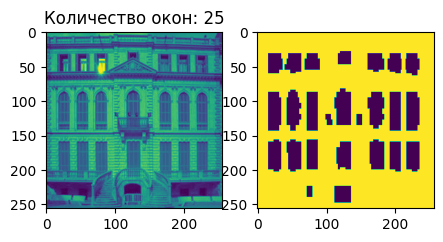

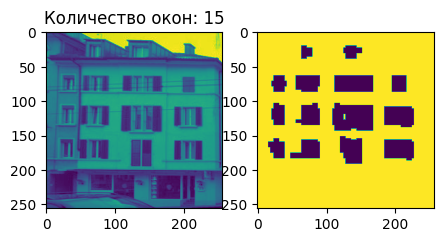

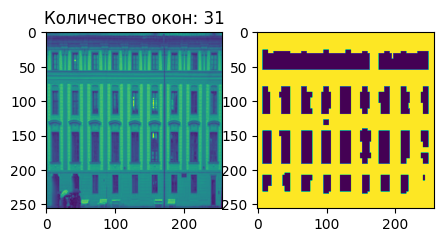

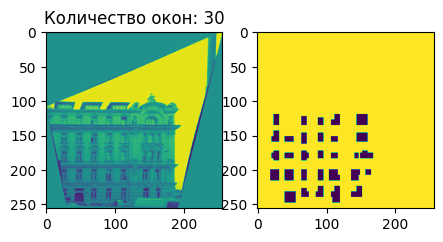

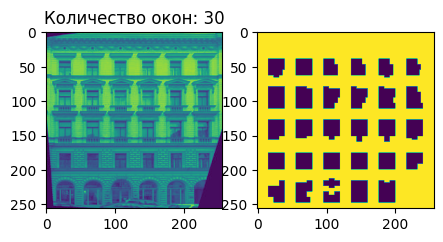

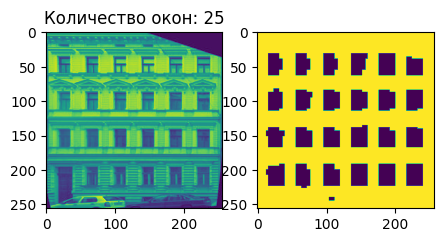

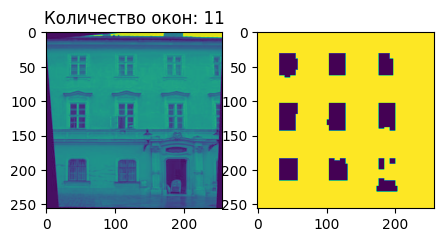

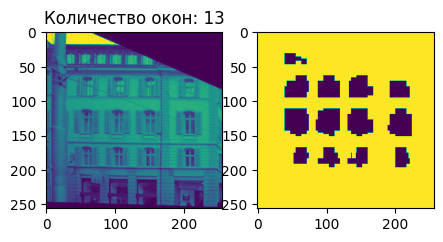

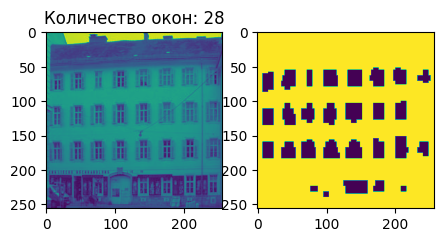

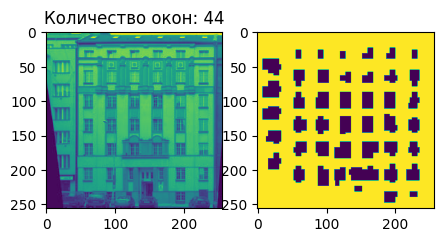

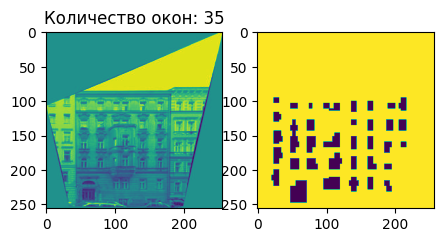

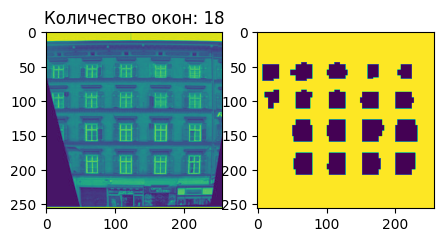

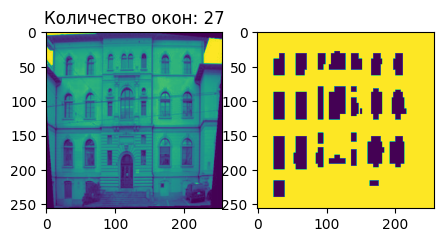

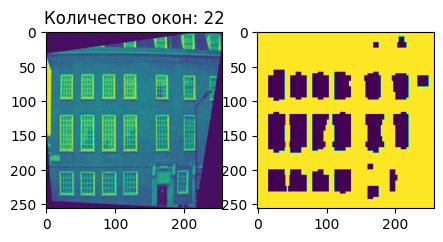

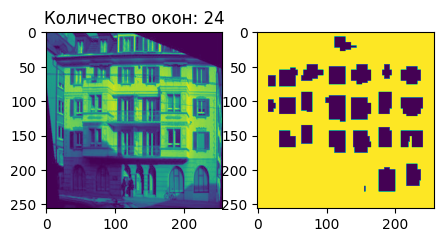

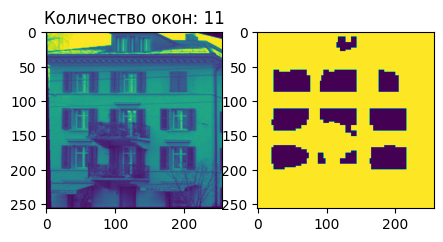

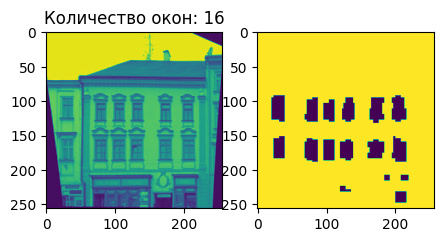

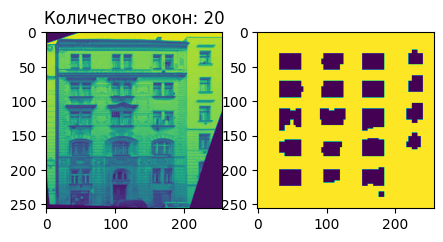

In [8]:
names = os.listdir('/home/mikhail/github/Facades/data/imgs_valid/')
for name in names:
    #делаем предсказание
    !python3 predict.py -i '/home/mikhail/github/Facades/data/imgs_valid/{name}' -o '/home/mikhail/github/Facades/data/predict_valid/{name}' --model '/home/mikhail/github/Facades/checkpoints/checkpoint_epoch10.pth'
    img = cv2.imread(f'/home/mikhail/github/Facades/data/imgs_valid/{name}',0)      
    mask = cv2.imread(f'/home/mikhail/github/Facades/data/predict_valid/{name}',0) 

    th, threshed = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU) 
    cnts = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2]    #находим контуры окон на изображении. Количество контуров
                                                                                # будет количеством окон

    threshed = threshed / 1.0
    mask = mask / 1.0
    plt.figure(figsize=(5,5))
    plt.subplot(1,2,1).imshow(img)
    plt.title('Количество окон: {}'.format(len(cnts)))
    plt.subplot(1,2,2).imshow(threshed)  


    #plt.figure(figsize=(5,5))
    #plt.subplot(1,2,1).imshow(img)
    #plt.subplot(1,2,2).imshow(mask)

Вывод:
Максимальное значение метрики Dice score, которое удалось получить 0.778.
Для улучшения качества модели необходимо больше данных и возможно следует более точно сделать разметку.